# DistMult Knowledge Graph Embedding


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys, os, json

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))
from task4_utils import (load_all_data, negative_sample, 
                         evaluate_link_prediction, evaluate_per_relation)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [2]:
# load data
TRAIN_PATH = 'data/train.txt'
TEST_PATH = 'data/test.txt'

data = load_all_data(TRAIN_PATH, TEST_PATH)
print(f"entities: {data['num_entities']}, relations: {data['num_relations']}")
print(f"train triplets: {len(data['train_ids'])}")
print(f"test triplets: {len(data['test_ids'])}")

entities: 1316, relations: 28
train triplets: 13821
test triplets: 590


## the model

DistMult is pretty simple:
- each entity gets a d-dimensional embedding vector
- each relation gets a d-dimensional embedding vector  
- score(h, r, t) = sum of elementwise product h * r * t
- higher score = more likely to be a true triplet

training: positive triplets should score higher than corrupted (negative) ones.

In [ ]:
class DistMult(nn.Module):
    def __init__(self, num_entities, num_relations, dim=200):
        super().__init__()
        self.entity_emb = nn.Embedding(num_entities, dim)
        self.relation_emb = nn.Embedding(num_relations, dim)
        
        # xavier init for stable training
        nn.init.xavier_uniform_(self.entity_emb.weight)
        nn.init.xavier_uniform_(self.relation_emb.weight)
    
    def score(self, h, r, t):
        
        h_emb = self.entity_emb(h)
        r_emb = self.relation_emb(r)
        t_emb = self.entity_emb(t)
        return torch.sum(h_emb * r_emb * t_emb, dim=1)
    
    def forward(self, triplets, labels):
        
        h = torch.LongTensor(triplets[:, 0]).to(device)
        r = torch.LongTensor(triplets[:, 1]).to(device)
        t = torch.LongTensor(triplets[:, 2]).to(device)
        
        labels = torch.FloatTensor(labels).to(device)
        
        scores = self.score(h, r, t)
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        

# CLAUDE ASSISTED CODE BELOW FOR L2 REGULARISATION (IDK WHAT IT IS)

        # light L2 regularization to prevent embedding blow-up
        reg = (self.entity_emb.weight.norm(p=2) ** 2 + 
               self.relation_emb.weight.norm(p=2) ** 2) / self.entity_emb.weight.shape[0]
        
        return loss + 0.001 * reg

## training loop

nothing fancy: sample negatives each epoch, shuffle, train with Adam.
we do a simple 90/10 split of training data for validation (early stopping on val loss).

In [4]:
# split train into train/val for early stopping
np.random.seed(42)
perm = np.random.permutation(len(data['train_ids']))
val_size = int(0.1 * len(perm))
val_idx = perm[:val_size]
train_idx = perm[val_size:]

train_triplets = data['train_ids'][train_idx]
val_triplets = data['train_ids'][val_idx]

print(f"training on {len(train_triplets)} triplets, validating on {len(val_triplets)}")

training on 12439 triplets, validating on 1382


In [5]:
# hyperparameters
DIM = 200
LR = 0.001
EPOCHS = 300
NEG_RATIO = 10
BATCH_SIZE = 512
PATIENCE = 30  # early stopping

model = DistMult(data['num_entities'], data['num_relations'], dim=DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_history = {'train': [], 'val': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    
    # sample negatives fresh each epoch
    all_trips, labels = negative_sample(train_triplets, data['num_entities'], neg_ratio=NEG_RATIO)
    
    # shuffle
    perm = np.random.permutation(len(all_trips))
    all_trips = all_trips[perm]
    labels = labels[perm]
    
    # mini-batch training
    epoch_loss = 0
    n_batches = 0
    for start in range(0, len(all_trips), BATCH_SIZE):
        batch_trips = all_trips[start:start + BATCH_SIZE]
        batch_labels = labels[start:start + BATCH_SIZE]
        
        loss = model(batch_trips, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_train_loss = epoch_loss / n_batches
    loss_history['train'].append(avg_train_loss)
    
    # validation loss
    model.eval()
    with torch.no_grad():
        val_all, val_labels = negative_sample(val_triplets, data['num_entities'], neg_ratio=NEG_RATIO)
        val_loss = model(val_all, val_labels).item()
        loss_history['val'].append(val_loss)
    
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'distmult_best.pt')
    else:
        patience_counter += 1
    
    if epoch % 25 == 0:
        print(f"epoch {epoch:3d} | train loss: {avg_train_loss:.4f} | val loss: {val_loss:.4f} | patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\nearly stopping at epoch {epoch}")
        break

print(f"\nbest val loss: {best_val_loss:.4f}")

epoch   0 | train loss: 0.6934 | val loss: 0.6934 | patience: 0/30
epoch  25 | train loss: 0.0361 | val loss: 0.0426 | patience: 3/30
epoch  50 | train loss: 0.0338 | val loss: 0.0430 | patience: 12/30

early stopping at epoch 68

best val loss: 0.0393


## loss curve

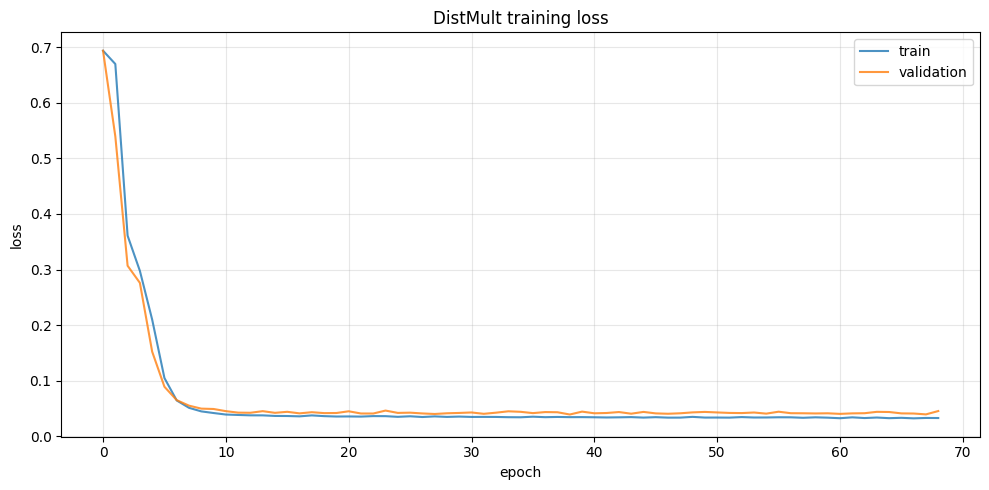

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history['train'], label='train', alpha=0.8)
plt.plot(loss_history['val'], label='validation', alpha=0.8)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('DistMult training loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('distmult_loss.png', dpi=150)
plt.show()

## evaluation

load best model and run filtered evaluation on test set.
"filtered" means: when ranking candidates for (h, r, ?), we remove other known 
true tails so they don't artificially inflate the rank.

In [7]:
# load best model
model.load_state_dict(torch.load('distmult_best.pt', weights_only=True))
model.eval()

# grab embeddings
with torch.no_grad():
    ent_emb = model.entity_emb.weight.detach().cpu().numpy()
    rel_emb = model.relation_emb.weight.detach().cpu().numpy()

print("running filtered evaluation on test set...")
results = evaluate_link_prediction(
    ent_emb, rel_emb, data['test_ids'], data['all_triplets_set'],
    data['num_entities'], score_fn='distmult'
)

running filtered evaluation on test set...
  evaluated 0/590 triplets...

  MRR:     0.7327
  Hits@1:  0.5737
  Hits@3:  0.8763
  Hits@10: 0.9992


## per-relation breakdown

the test only has motherOf, fatherOf, sonOf, daughterOf.
let's see if the model finds some easier than others.

In [8]:
print("\nper-relation metrics:")
per_rel = evaluate_per_relation(
    ent_emb, rel_emb, data['test_ids'], data['all_triplets_set'],
    data['num_entities'], data['id2relation'], score_fn='distmult'
)

for rel_name, metrics in sorted(per_rel.items()):
    print(f"\n  {rel_name}:")
    print(f"    MRR: {metrics['mrr']:.4f}  Hits@1: {metrics['hits@1']:.4f}  "
          f"Hits@3: {metrics['hits@3']:.4f}  Hits@10: {metrics['hits@10']:.4f}")


per-relation metrics:

  daughterOf:
    MRR: 0.7010  Hits@1: 0.5300  Hits@3: 0.8525  Hits@10: 1.0000

  fatherOf:
    MRR: 0.8316  Hits@1: 0.7159  Hits@3: 0.9318  Hits@10: 1.0000

  motherOf:
    MRR: 0.8099  Hits@1: 0.6875  Hits@3: 0.9205  Hits@10: 1.0000

  sonOf:
    MRR: 0.6900  Hits@1: 0.5093  Hits@3: 0.8575  Hits@10: 0.9977


## save results for comparison later

In [ ]:
# LLM made this code block to save results and embeddings for the analysis notebook
#  save for the analysis notebook CLAUDE GENERATED CODE BLOCK
distmult_results = {
    'overall': {k: float(v) for k, v in results.items() if k != 'all_ranks'},
    'per_relation': {r: {k: float(v) for k, v in m.items()} for r, m in per_rel.items()},
    'loss_history': loss_history,
    'config': {'dim': DIM, 'lr': LR, 'neg_ratio': NEG_RATIO, 'epochs_trained': len(loss_history['train'])}
}

with open('distmult_results.json', 'w') as f:
    json.dump(distmult_results, f, indent=2)

# save embeddings for visualization
np.save('distmult_entity_emb.npy', ent_emb)
np.save('distmult_relation_emb.npy', rel_emb)

print("saved distmult_results.json and embedding files")

saved distmult_results.json and embedding files


## quick observations

- DistMult is surprisingly effective for such a simple model
- the bilinear scoring function handles the symmetric nature of family relationships
- sonOf/daughterOf are essentially inverses of fatherOf/motherOf
- interesting to see if the model captures this or treats them independently